In [112]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import sklearn
import matplotlib.pyplot as plt
import nltk

from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, PCA, NMF, FastICA, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from nltk.corpus import stopwords
nltk.download('stopwords')

stop_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/dtrckd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [6]:
# Swow some exemples
print("datasets dict keys:", list(newsgroups))
print("type of the data sample:", type(newsgroups["data"][0]))
print("number of samples:", len(newsgroups["data"]))
print("target names:", newsgroups["target_names"])
print("unique target in dataset:", np.unique(newsgroups["target"]))
assert(len(newsgroups["target"]) == len(newsgroups["data"]))
print("DESCR:", newsgroups["DESCR"][:1000])

datasets dict keys: ['data', 'filenames', 'target_names', 'target', 'DESCR']
type of the data sample: <class 'str'>
number of samples: 18846
target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
unique target in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
DESCR: .. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages po

In [13]:
# Vectorize the corpus
corpus = newsgroups["data"]
stop_words_ext = list(stop_en)

stop_words_ext = list(stop_en) 
vectorizer = CountVectorizer(stop_words=stop_words_ext, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z_-]+\b")

# fit_transform is equivalent successive calls to:
#vectorizer.fit()
#vectorizer.transform(corpus)
X = vectorizer.fit_transform(corpus)
y = newsgroups["target"]

In [14]:
import sys
print("Size of voc:", len(vectorizer.get_feature_names_out()))
# Vocabulary is in alphabetic order...
print("The first word of the vocabulary: ", vectorizer.get_feature_names_out()[:10])
# The 10th first words frequency for the first document...
X[0, :10].toarray()

Size of voc: 100858
The first word of the vocabulary:  ['a-' 'a--' 'a-arm' 'a-b' 'a-bloody-gen' 'a-bomb' 'a-bombs' 'a-c'
 'a-codes' 'a-d']


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [17]:
#
# Utils
#

# Compute some unsupervised score for the given model
def bench_k_means(estimator, data, y=None):
    #stimator.fit(data)
    scores = [
        "adjusted_mutual_info_score",
        "silhouette_score",
    ]

    results = []
    for s in scores:
        if s not in ["silhouette_score"]:
            # with ground-truth
            # Yeah !
            score = getattr(metrics, s)(y, estimator.labels_)
        elif y is not None:
            # with NO ground-truth
            score = getattr(metrics, s)(data, estimator.labels_)
        else:
            continue
            
        results.append(score)
        
    return pd.DataFrame([results], columns=scores, index=["result"])



In [85]:
# Clustering with two fundemental vectorizing approach
# count and tfidf vectorizers.

from time import time

all_pipes = [
    Pipeline([
        ('count', CountVectorizer(stop_words=stop_words_ext)),
        ('kmeans', KMeans(n_clusters=20))
    ]),
    Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words_ext)),
        ('kmeans', KMeans(n_clusters=20))]
    )
]

results = []
for p in all_pipes:
    now = time()
    steps = list(p.named_steps.values())
    vectorizer = steps[0]
    kmeans_model = steps[1]
    
    X = vectorizer.fit_transform(corpus)
    kmeans_model.fit(X)
    print("%s training time: %.1f seconds" % ("-".join(list(p.named_steps)), time() - now))
    kmeans_model = p.named_steps["kmeans"]
    results.append(bench_k_means(kmeans_model, X, y).round(2))

# Show result table
df = pd.concat(results)
df.index = ["-".join(list(p.named_steps)) for p in all_pipes]
df

/home/dtrckd/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


count-kmeans training time: 28.8 seconds


/home/dtrckd/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


tfidf-kmeans training time: 62.0 seconds


,adjusted_mutual_info_score,silhouette_score
count-kmeans,0.00,0.91
tfidf-kmeans,0.32,0.00


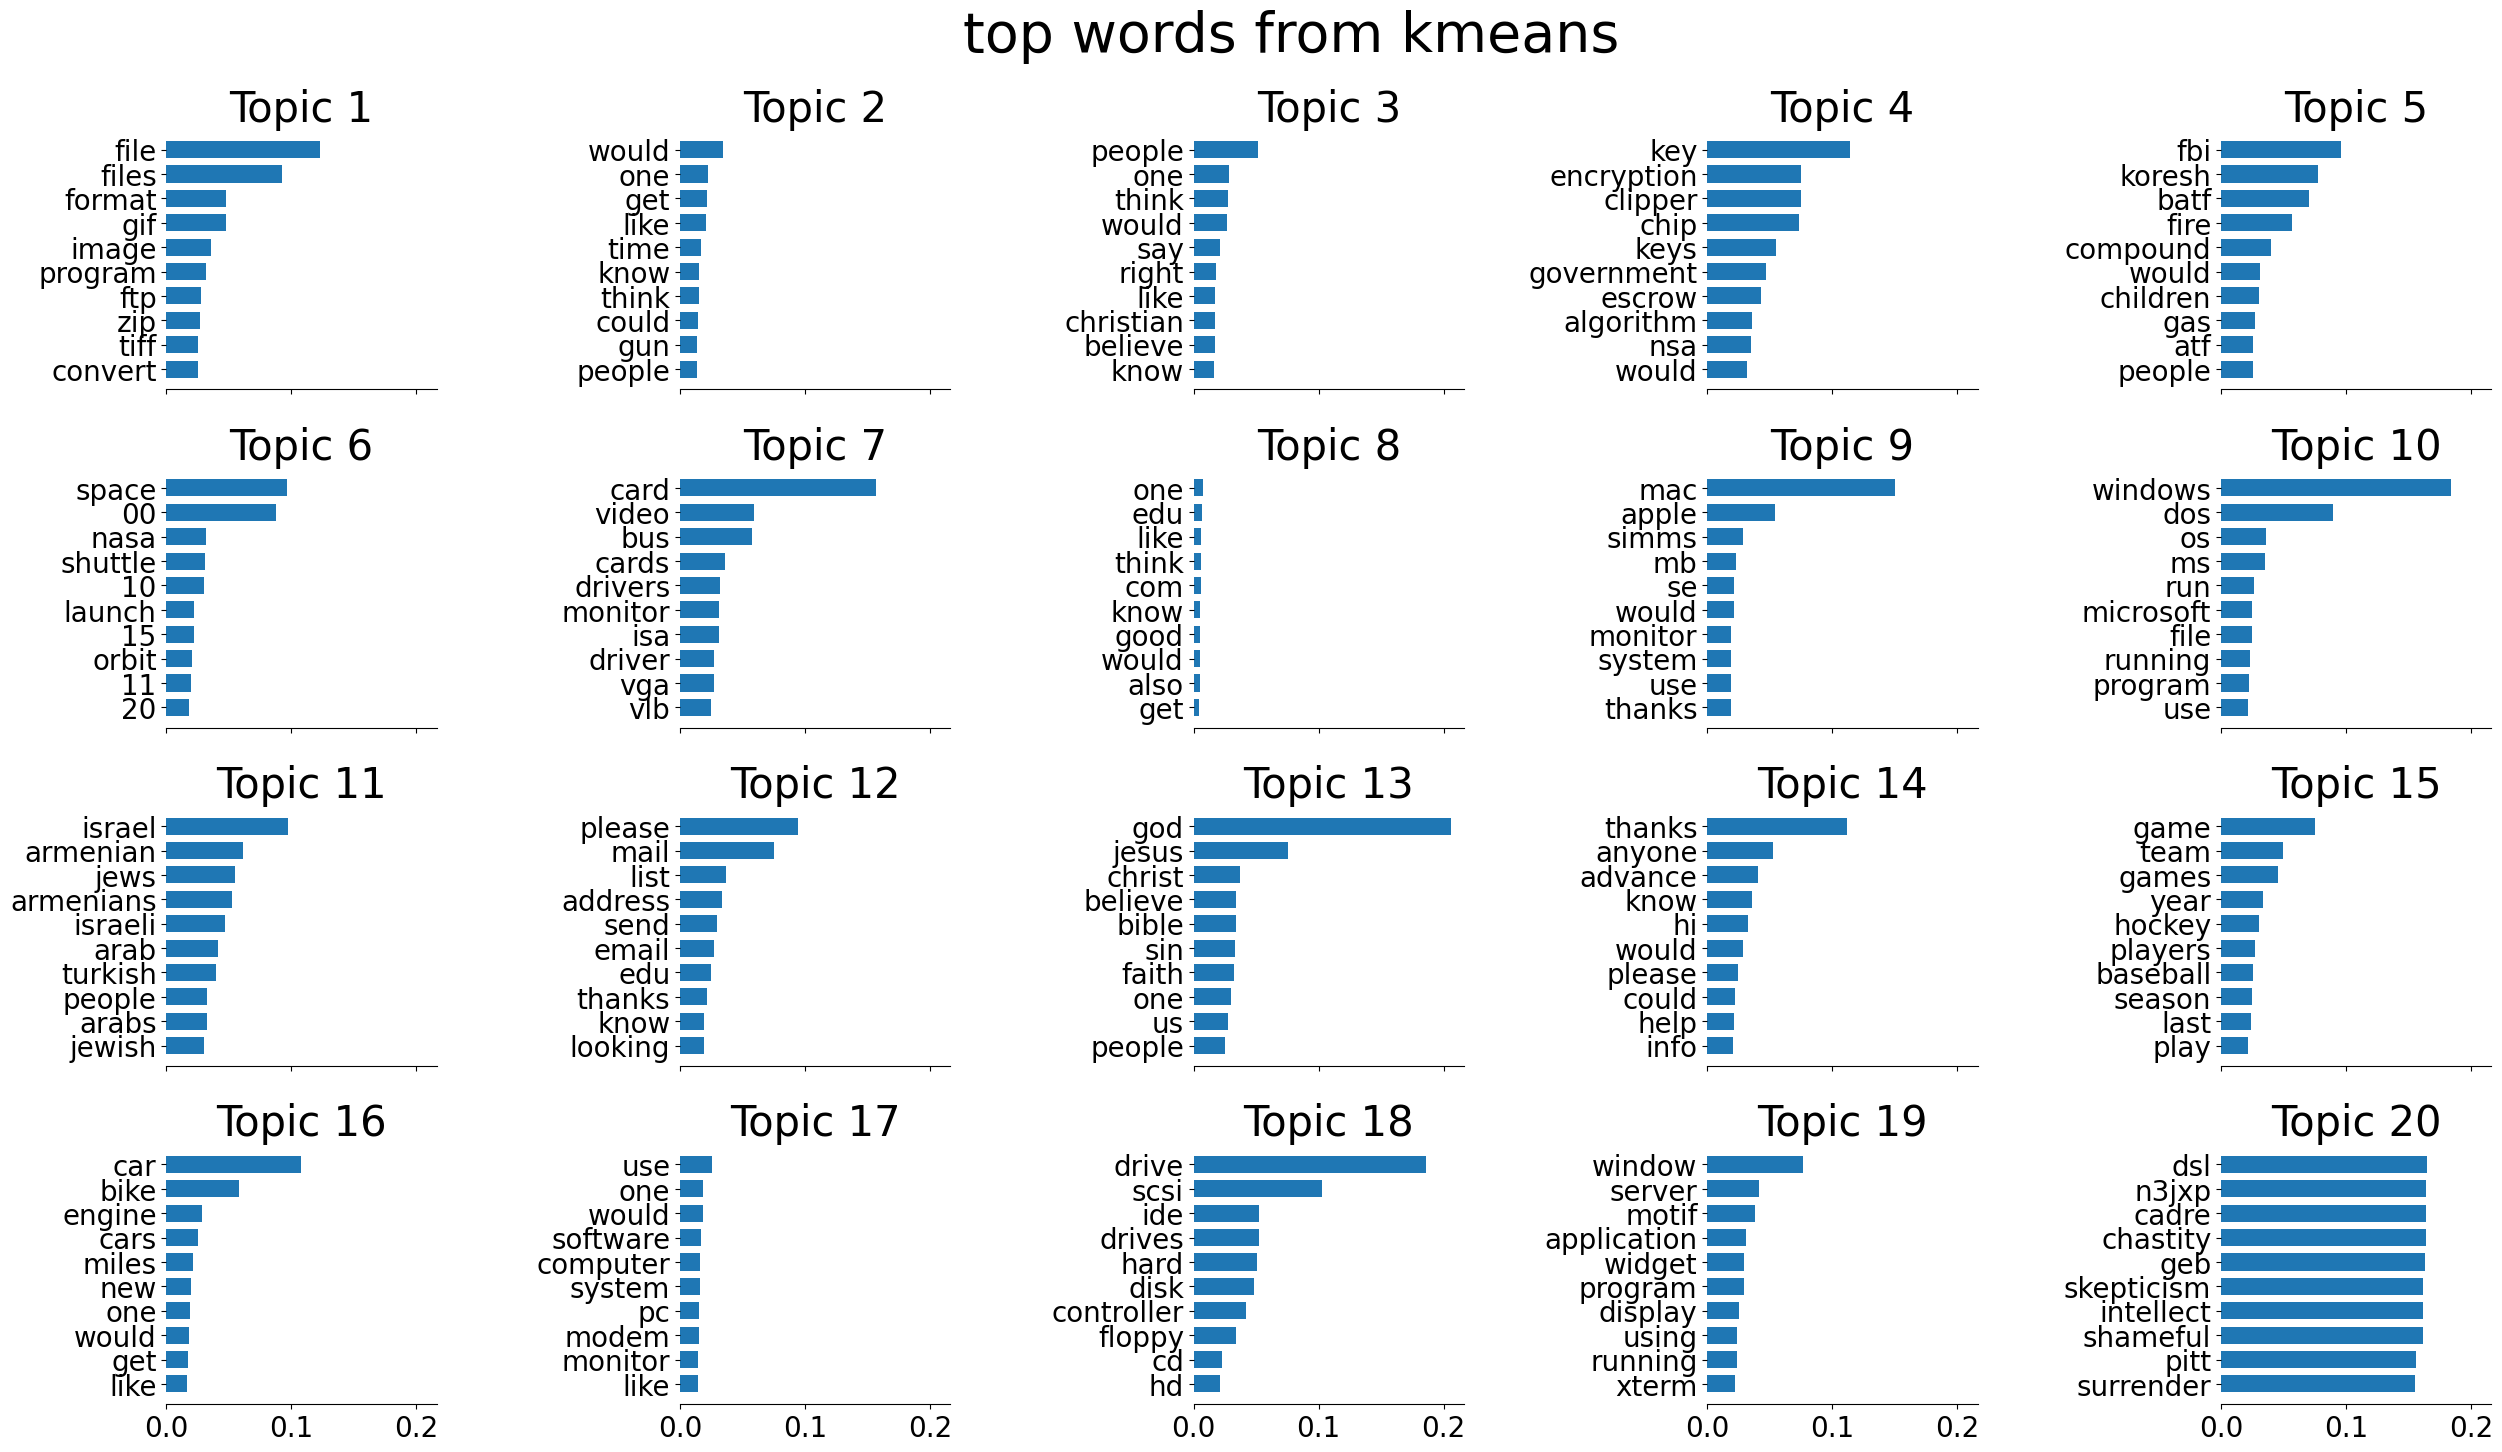

In [96]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.cluster_centers_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Takes vectorizer from the given pipe
best_pipe = 1
vectorizer = all_pipes[best_pipe][0]
model = all_pipes[best_pipe][-1]

vocab = vectorizer.get_feature_names_out()
plot_top_words(model, vocab, 10, 'top words from kmeans') 

In [132]:
# Heuristic to assign a real class/target to a cluster 
# - for each cluster we will look thte class that that appear most frequently in the doc assign to that cluster

def get_cluster_to_target(estimator, targets):
    cluster_to_target = {}
    for cluster_k in range(estimator.get_params()["n_clusters"]):
        # Find the target of the doc in the cluster
        target_for_cluster_k = targets[estimator.labels_ == cluster_k]
        # Most representative target in this cluster
        best_target = np.bincount(target_for_cluster_k).argmax()
        cluster_to_target[cluster_k] = best_target

    return cluster_to_target

# Find which target is not mapped to a cluster
orphan_target = np.where(np.bincount(list(cluster_to_target.values())) == 0)[0]
print("Orphan targets:", orphan_target)

Orphan targets: [0 9]


In [147]:
# Compare a classification algorithm with a classification algorithm for target prediction !

X = corpus
y = newsgroups["target"]

# Create train and test set from the originale data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

class KMeansClassifier(KMeans):
    # Super-charge the Kmeans class
    # to use it like a classifier 8>
    
    def fit(self, X, y):
        # Execute the fit function from the mother class
        super().fit(X)
        # save the cluster to target dict into the object attributes
        self.cluster_to_target =  get_cluster_to_target(self, y)
        
    def predict(self, X):
         # Execute the predict function from the mother class
        cluster_assignements = super().predict(X)
        # map the cluster to target class.
        y_pred = [self.cluster_to_target[k] for k in cluster_assignements]
        return y_pred
        

all_pipes_clf = [
    Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words_ext)),
        ('svm', SGDClassifier(loss="hinge"))
    ]),
    Pipeline([
         ('tfidf', TfidfVectorizer(stop_words=stop_words_ext)), 
         ('svd', TruncatedSVD(n_components=100)),
         ('kmeans-clf', KMeansClassifier(n_clusters=20, n_init="auto"))
        ]),
    Pipeline([
         ('tfidf', TfidfVectorizer(stop_words=stop_words_ext)), 
         ('svd', TruncatedSVD(n_components=100)),
         ('scaler', StandardScaler()),
         ('kmeans-clf', KMeansClassifier(n_clusters=20, n_init="auto"))
    ]),
     Pipeline([
         ('tfidf2', TfidfVectorizer(stop_words=stop_words_ext, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z_-]+\b")), 
         ('svd', TruncatedSVD(n_components=100)),
         ('kmeans-clf', KMeansClassifier(n_clusters=20, n_init="auto"))
    ]),
    # Pipeline([
    #     ('tfidf2', TfidfVectorizer(stop_words=stop_words_ext, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z_-]+\b")), 
    #     ('NMF', NMF(n_components=100)),
    #     ('kmeans-clf', KMeansClassifier(n_clusters=20, n_init="auto"))
    # ]),
    Pipeline([
        ('count', CountVectorizer(stop_words=stop_words_ext)), 
        ('LDA', LatentDirichletAllocation(n_components=100)),
        ('kmeans-clf', KMeansClassifier(n_clusters=20, n_init="auto"))
    ]),
]

results = []
for p in all_pipes_clf:
    now = time()
    p.fit(x_train, y_train)
    y_pred = p.predict(x_test)
    print("%s training time: %.1f seconds" % ("-".join(list(p.named_steps)), time() - now))
    # Hey accuracy ~ to micro avg f1 score
    # better to use the 
    results.append({
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "weighted avg f1": metrics.f1_score(y_test, y_pred, average="weighted"),
        "report": classification_report(y_test, y_pred, target_names=newsgroups["target_names"], zero_division=0),
    })


df = pd.DataFrame(results)
df.index = ["-".join(list(p.named_steps)) for p in all_pipes_clf]
df.drop("report", axis=1, inplace=True)
df

tfidf-svm training time: 5.0 seconds
tfidf-svd-kmeans-clf training time: 16.7 seconds
tfidf-svd-scaler-kmeans-clf training time: 17.9 seconds
tfidf2-svd-kmeans-clf training time: 14.5 seconds
count-LDA-kmeans-clf training time: 167.3 seconds


,accuracy,weighted avg f1
tfidf-svm,0.766844,0.763969
tfidf-svd-kmeans-clf,0.272149,0.252605
tfidf-svd-scaler-kmeans-clf,0.218833,0.222996
tfidf2-svd-kmeans-clf,0.309549,0.318464
count-LDA-kmeans-clf,0.284085,0.267247


In [144]:
# Show global reports
for i, res in enumerate(results):
    name = "-".join(list(all_pipes_clf[i].named_steps))
    print(f'{name} scores : \n {res["report"]}')

tfidf-svm scores : 
                           precision    recall  f1-score   support

             alt.atheism       0.76      0.60      0.67       171
           comp.graphics       0.75      0.74      0.74       193
 comp.os.ms-windows.misc       0.72      0.73      0.73       192
comp.sys.ibm.pc.hardware       0.75      0.68      0.71       193
   comp.sys.mac.hardware       0.78      0.73      0.76       179
          comp.windows.x       0.81      0.82      0.82       186
            misc.forsale       0.77      0.78      0.77       214
               rec.autos       0.78      0.73      0.75       206
         rec.motorcycles       0.53      0.81      0.64       190
      rec.sport.baseball       0.89      0.86      0.87       217
        rec.sport.hockey       0.89      0.89      0.89       195
               sci.crypt       0.86      0.89      0.88       190
         sci.electronics       0.80      0.75      0.77       199
                 sci.med       0.80      0.90      0.8